In [8]:
import gensim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
model_file = '/home/dafne/shared/FilterBubble/word-embeddings/fasttext.model.bin'
emb = gensim.models.fasttext.load_facebook_model(model_file)

In [4]:
df_issues = pd.read_csv('/home/dafne/shared/FilterBubble/issue-positions/queries-asterix-expanded.csv')
df_issues.head()

,Unnamed: 0,query,issue,category,vocab
0,0,3 procent,EuropeseUnie,original,False
1,1,60 procent,EuropeseUnie,original,False
2,2,brexit,EuropeseUnie,original,True
3,3,coronaherstelfonds,EuropeseUnie,original,True
4,4,ECB,EuropeseUnie,original,False


## Explore relation between expanded and original words
First we calculate the pairwise cosine similarities between all words for an issue. Then we take as edges pairs with a similarity above a cut-off value and create a network from this.

In [28]:
def get_pairwise_similarities(issue, df_issues):
    df_sub = df_issues[(df_issues.issue==issue)].copy()
    df_sub['query'] = df_sub['query'].str.replace('*', '')
    queries = df_sub['query'].unique()
    vectors = emb.wv[queries]
    sim = np.array([emb.wv.cosine_similarities(x, vectors) for x in vectors])
    return pd.DataFrame(sim, columns=queries, index=queries)

In [29]:
# This code takes some time to run
calculate_again = False

if calculate_again:
    out_path = '/home/dafne/shared/FilterBubble/issue-positions/query-networks/wildcard-expansion/similarities/'
    for issue, n in df_issues.issue.value_counts(sort=False).to_dict().items():
        print(issue)
        df_sim = get_pairwise_similarities(issue, df_issues)
        df_sim.to_csv(os.path.join(out_path, issue+'.csv'))

ontwikkelingCrim
coronabestrijding
vrijheidsrechten
werk
woning
ontwikHulp
coronaverspreiding
EuropeseUnie
bestrijdingCrim
Infrastructuur
socZek
klimaatMilieu
normenWaarden
geZorg
begrotingssaldo
OenW
bestVernieuw
belastHeffing
terreurbestrijding
integratie
ondernemingsklimaat


We look at the distribution of pairwise similarities for each issue.
Some issues seem more coherent, that is the similarities are at the higher end of the spectrum. Some have a quite wide distribution: this could mean that the issue consists of multiple sub-themes.

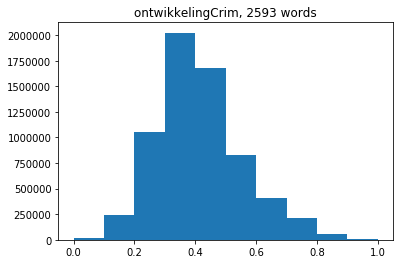

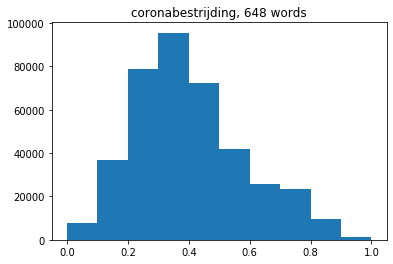

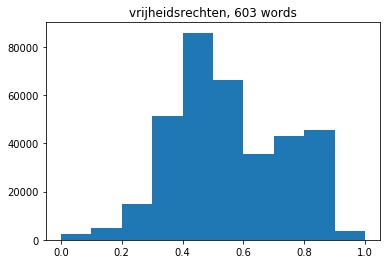

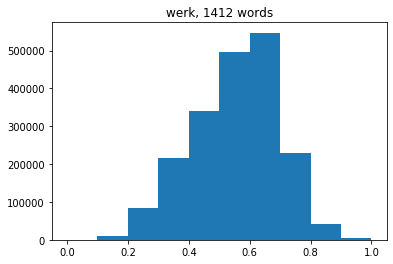

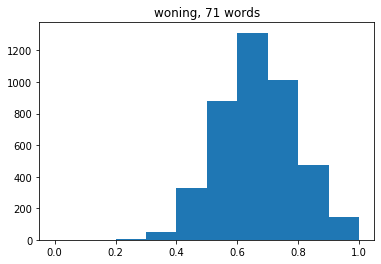

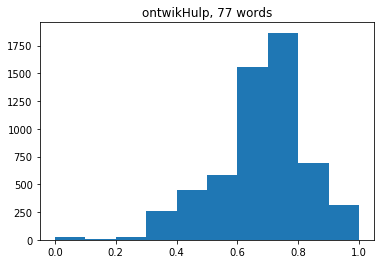

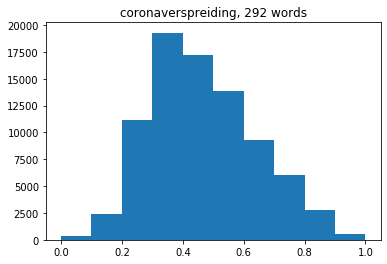

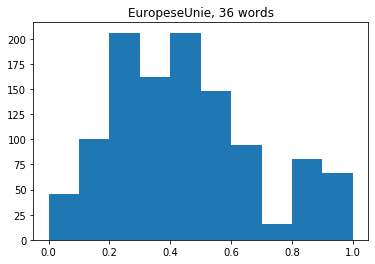

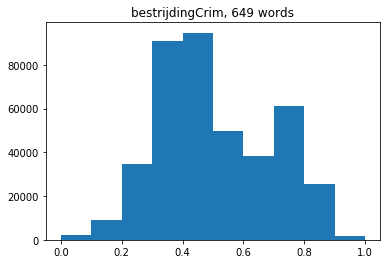

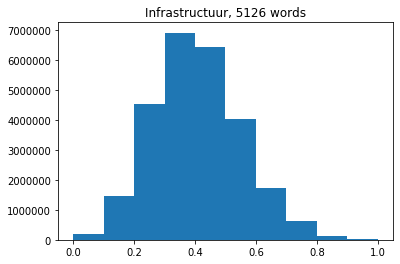

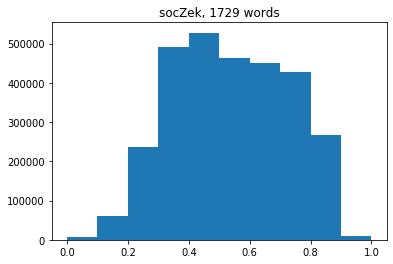

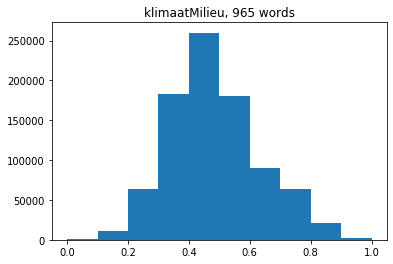

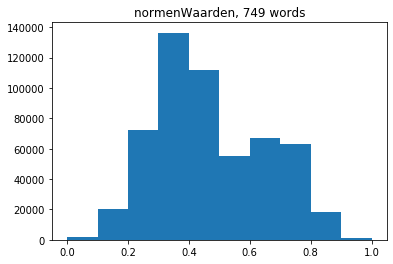

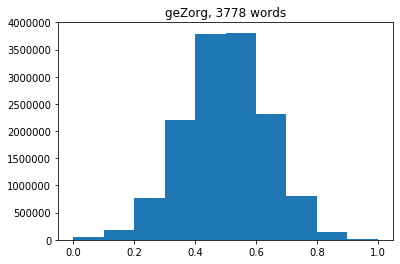

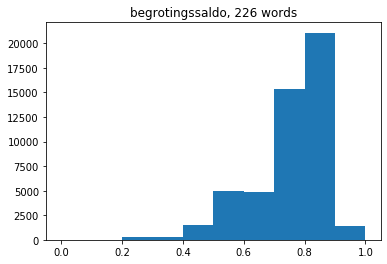

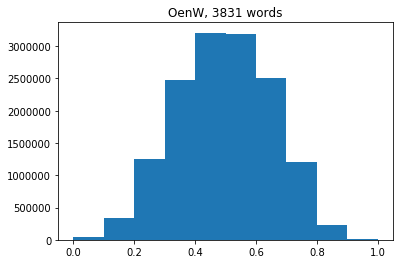

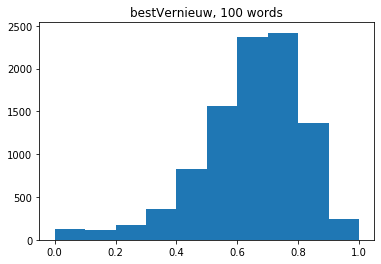

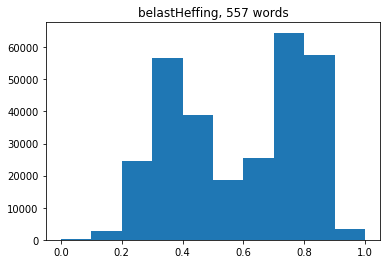

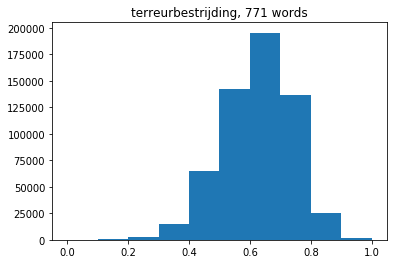

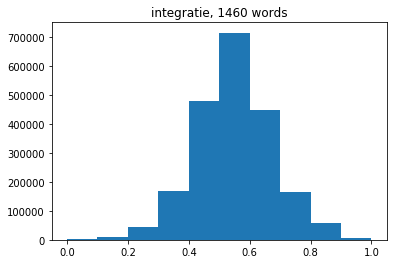

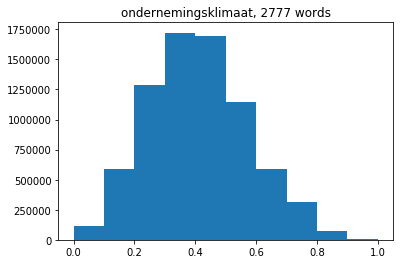

In [30]:
in_path = '/home/dafne/shared/FilterBubble/issue-positions/query-networks/wildcard-expansion/similarities/'
for issue, n in df_issues.issue.value_counts(sort=False).to_dict().items():
    df_sim = pd.read_csv(os.path.join(in_path, issue+'.csv'), index_col=0)
    plt.hist(df_sim.values.flatten(), bins=np.arange(0, 1.1, 0.1))
    plt.title('{}, {} words'.format(issue, n))
    plt.show()

## drawing the networks
We convert the pairwise similarities to networks, by defining edges for pairs of words that have a similarity above a certain threshold value.

In [68]:
def draw_network(graph, issue):
    color_map = {'original': 'green',
            'expanded': 'grey',
            'wildcard': 'yellow'}
    
    plt.figure(figsize=(20,20))
    nx.set_node_attributes(graph, 
                           {k: color_map[v] for k,v in nx.get_node_attributes(graph, 'category').items()}, 
                           'color')
    nx.draw_networkx(graph, 
                 node_color=nx.get_node_attributes(graph, 'color').values(), 
                 with_labels=True, 
                 pos=nx.spring_layout(graph, weight='weight', scale=10)
                )
    plt.title(issue)
    plt.show()

In [69]:
def get_network(df_sim, df_issues, cut_off=0.6):
    # Get part of the dataframe for this issue
    df_sub = df_issues[(df_issues.issue==issue)].copy()
    df_sub['query'] = df_sub['query'].str.replace('*', '')
    
    # Only take elements above threshold, and only above diagonal
    df_half = pd.DataFrame(np.triu(df_sim, 1), columns=df_sim.columns, index=df_sim.index)
    df_edges = df_half[df_half>cut_off].stack().reset_index()
    df_edges.columns = ['source', 'target', 'weight']
    
    # Create networkx graph
    graph = nx.from_pandas_edgelist(df_edges, edge_attr='weight')
    categories = dict(df_sub[['query', 'category']].values)
    nx.set_node_attributes(graph, categories, 'category')

    return graph

We draw a few of the networks (only the smaller ones)

Automatic pdb calling has been turned OFF


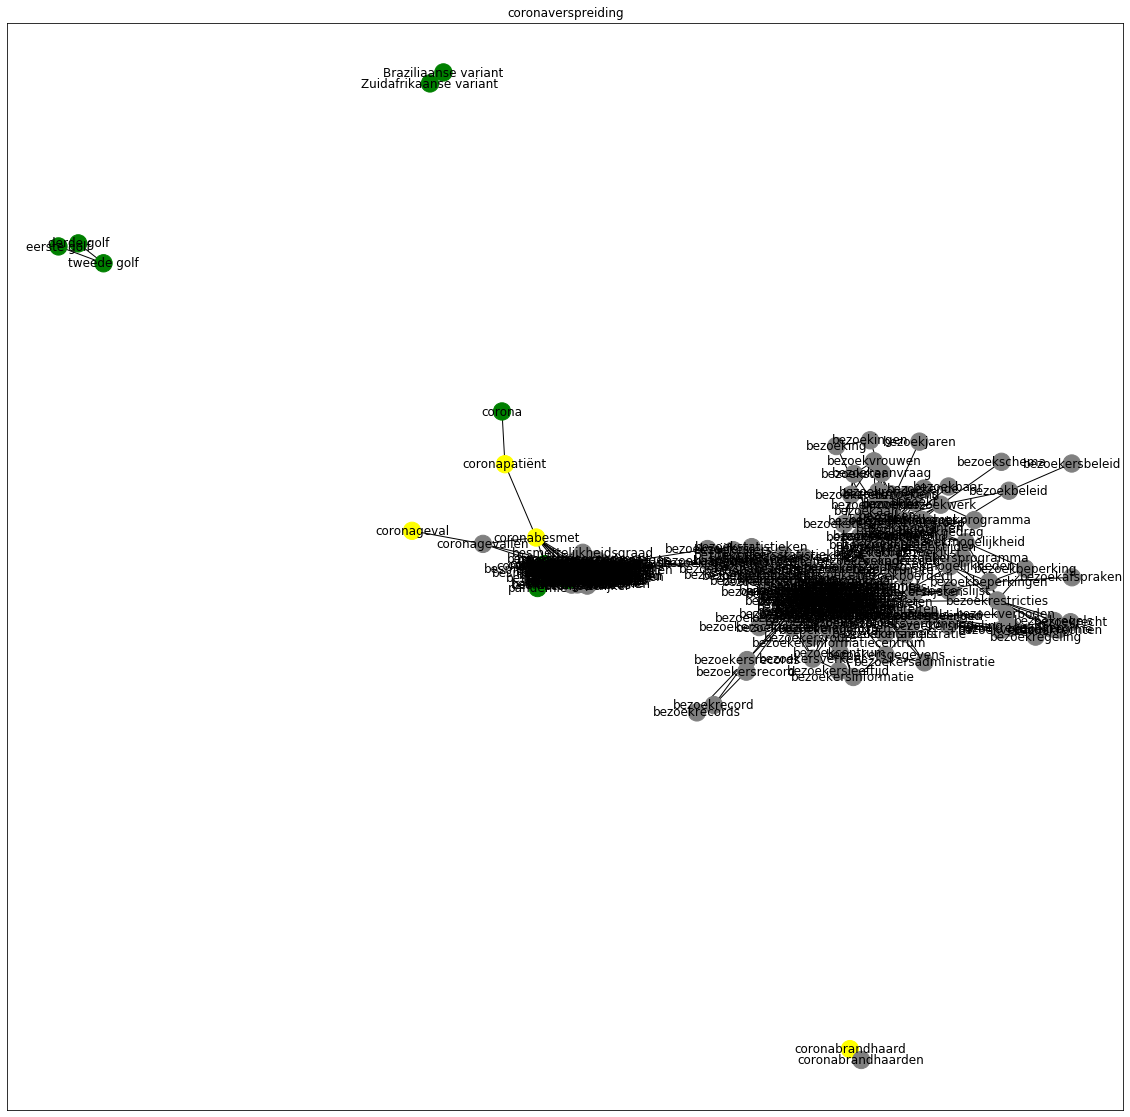

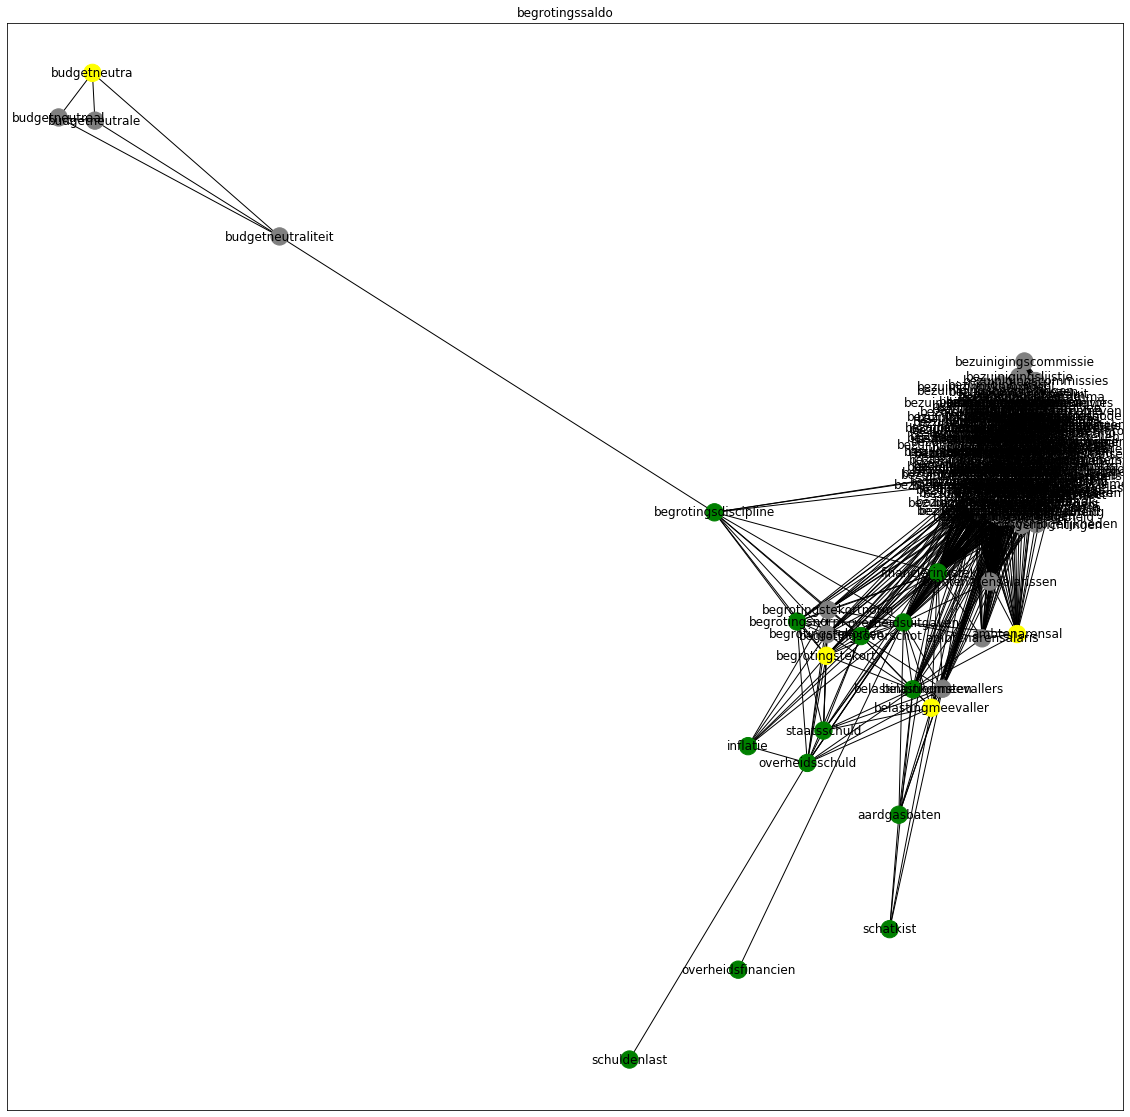

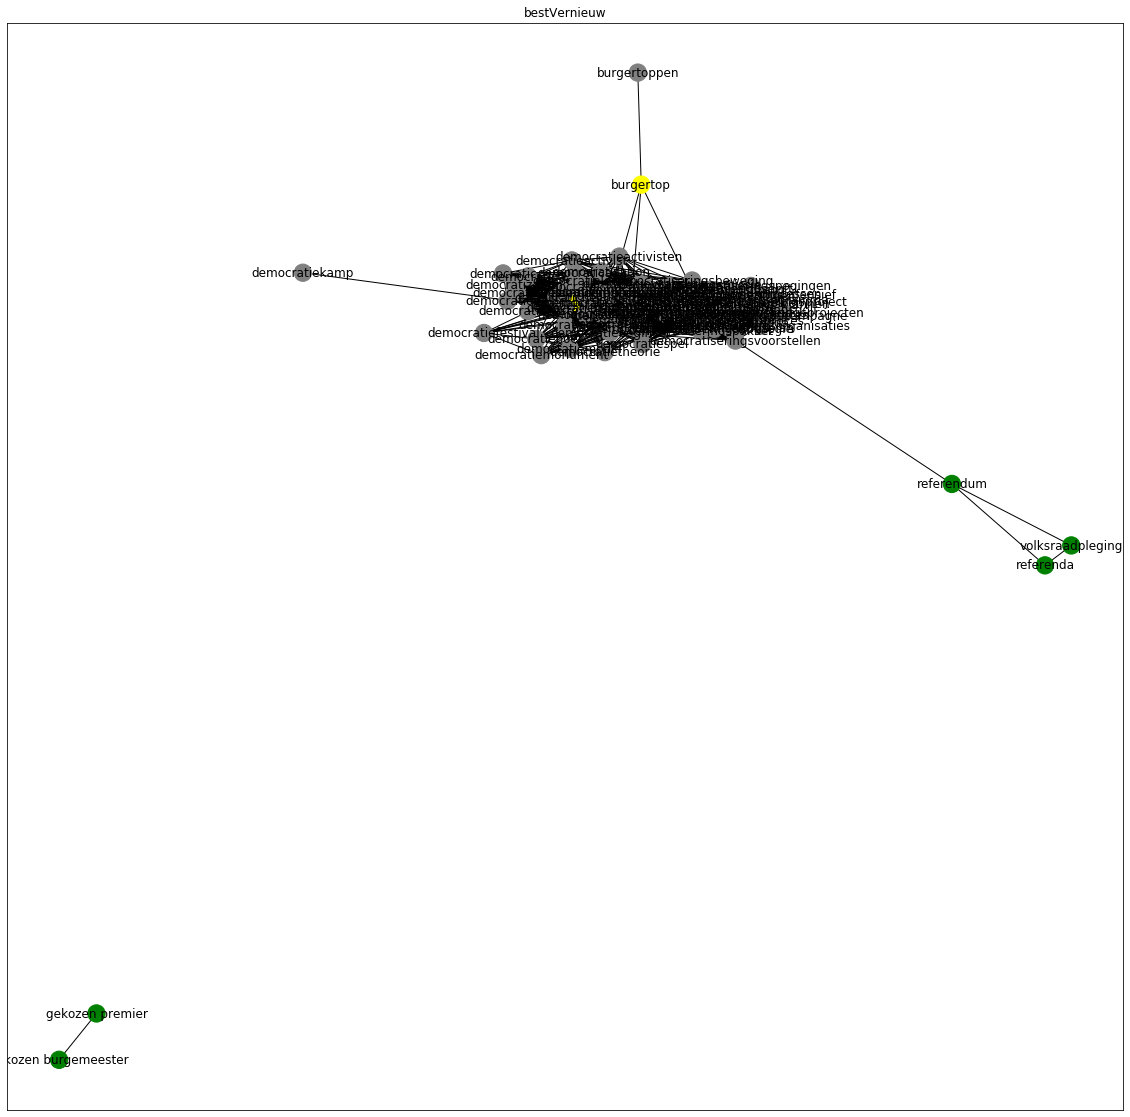

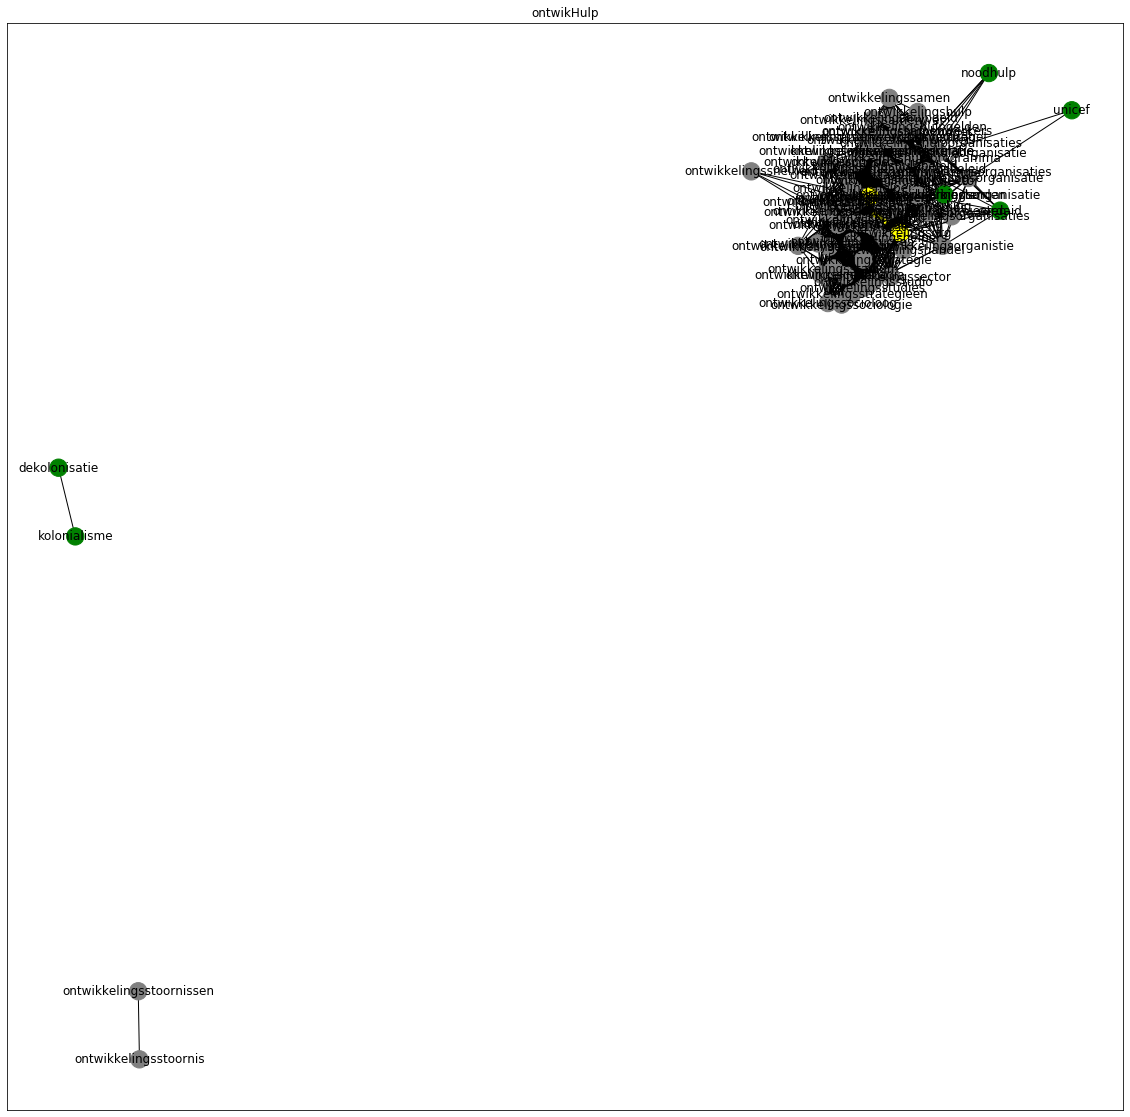

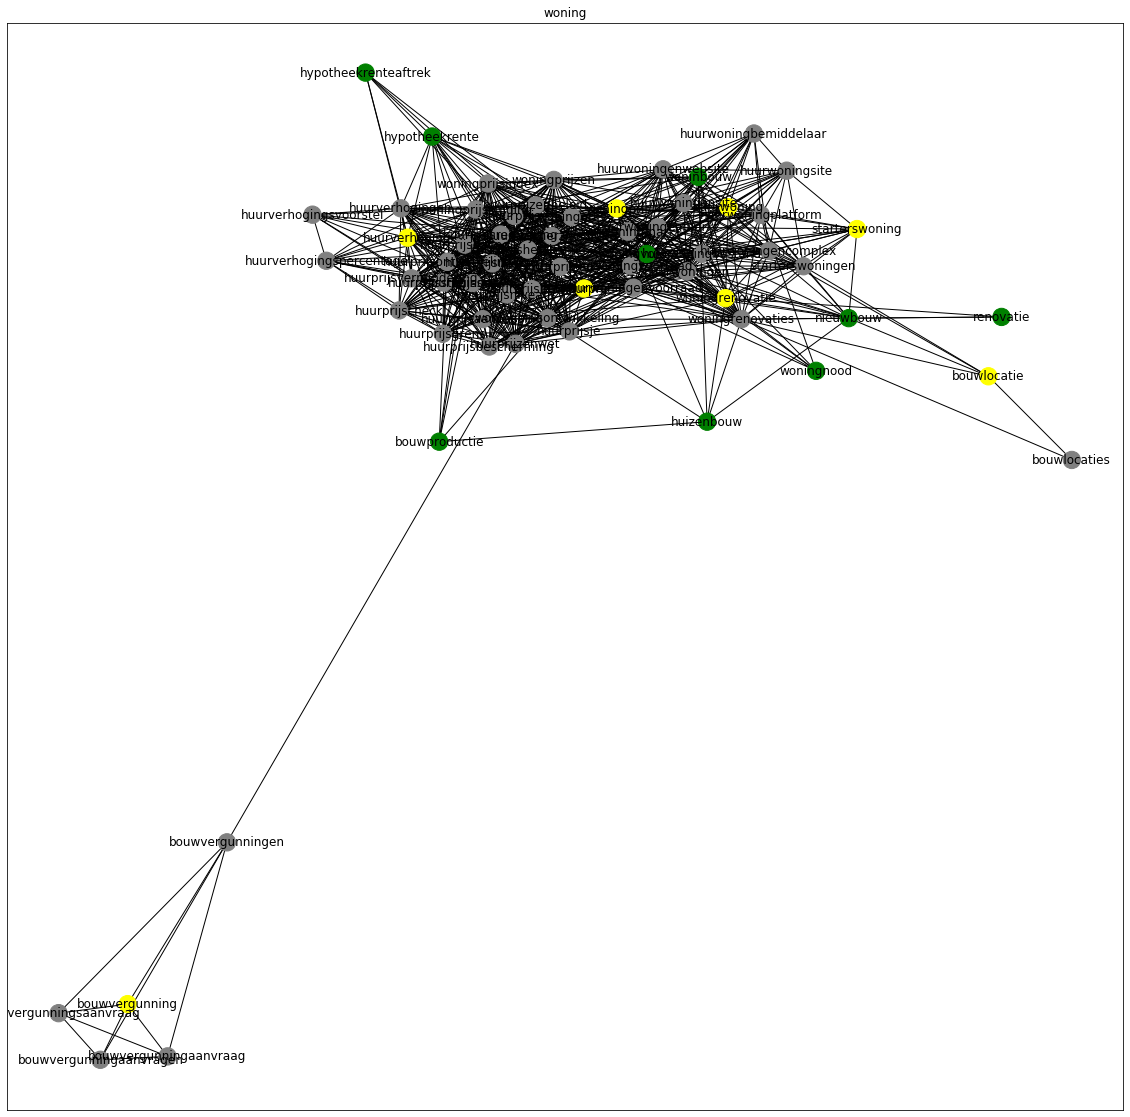

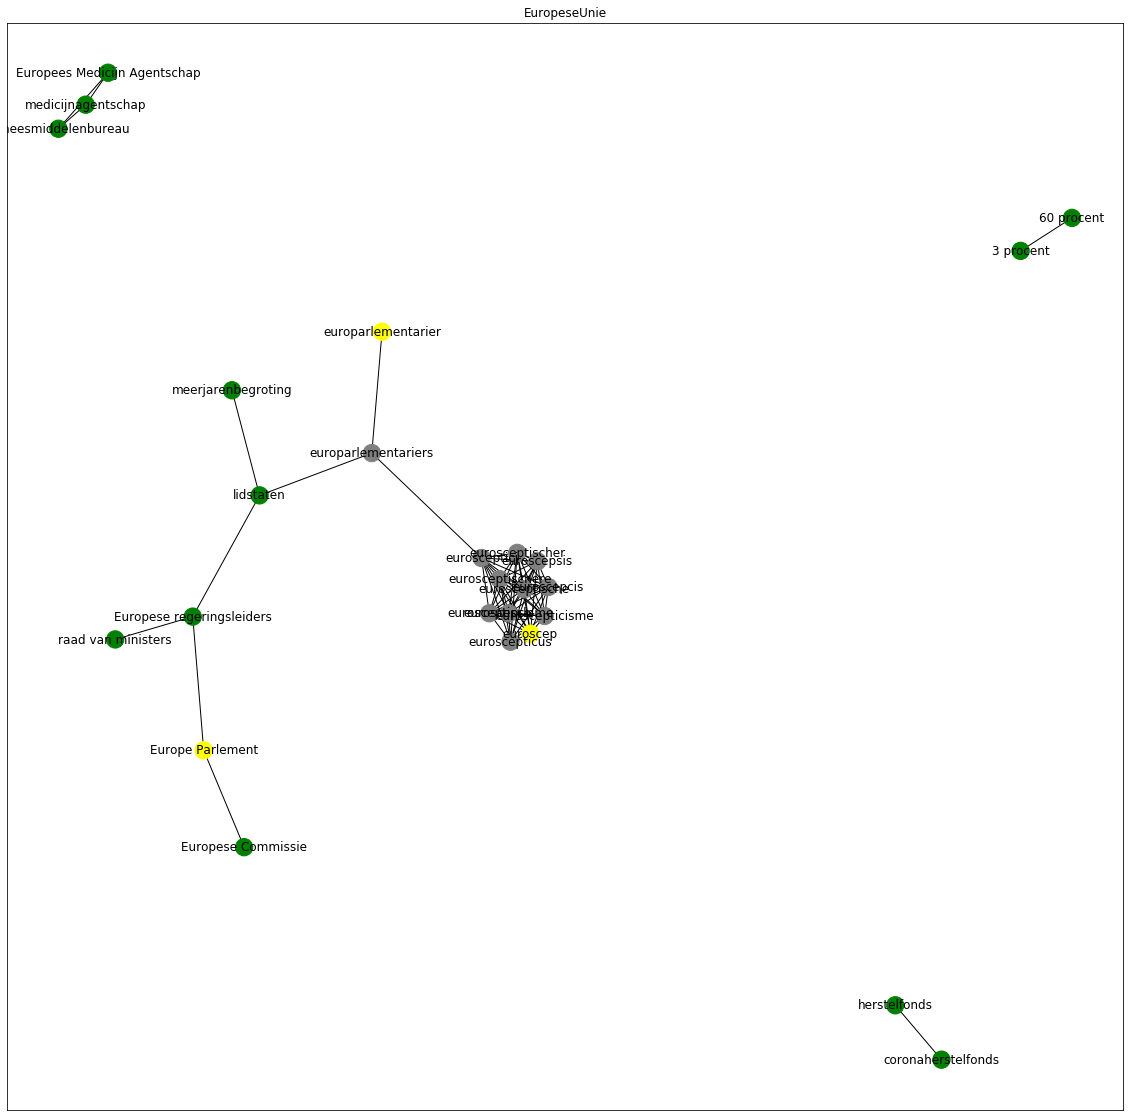

In [71]:
for issue, n in df_issues.issue.value_counts().to_dict().items():
    if n < 500:
        df_sim = pd.read_csv(os.path.join(in_path, issue+'.csv'), index_col=0)
        graph = get_network(df_sim, df_issues, cut_off=0.7)
        draw_network(graph, issue)

In [72]:
# Write the networks to files, including many more edges
out_path = '/home/dafne/shared/FilterBubble/issue-positions/query-networks/wildcard-expansion/cutoff-0.8'
for issue, n in df_issues.issue.value_counts(sort=False).to_dict().items():
    print(issue)
    graph = get_network(df_sim, df_issues, cut_off=0.8)
    nx.write_gexf(graph, os.path.join(out_path, '{}.gexf'.format(issue)))

ontwikkelingCrim
coronabestrijding
vrijheidsrechten
werk
woning
ontwikHulp
coronaverspreiding
EuropeseUnie
bestrijdingCrim
Infrastructuur
socZek
klimaatMilieu
normenWaarden
geZorg
begrotingssaldo
OenW
bestVernieuw
belastHeffing
terreurbestrijding
integratie
ondernemingsklimaat


In [ ]:
out_path = '/home/dafne/shared/FilterBubble/issue-positions/query-networks/wildcard-expansion/cutoff-0.7'
for issue, n in df_issues.issue.value_counts(sort=False).to_dict().items():
    print(issue)
    graph = get_network(df_sim, df_issues, cut_off=0.7)
    nx.write_gexf(graph, os.path.join(out_path, '{}.gexf'.format(issue)))

## Explore relation with nearest neighbors
We now further explore the 'woning' issue, since the query set seems quite cohesive in the graph above, and the number of query terms is small enough to see that there is no false positives in there.

We will now look at the nearest neighbors of each of the individual query terms, and draw edges between nodes if they are in the top-n Nearest neighbors.

In [88]:
issue = 'woning'
df_sub = df_issues[(df_issues.issue==issue)].copy()
df_sub['query'] = df_sub['query'].str.replace('*', '')

categories = dict(df_sub[['query', 'category']].values)
color_map = {'original': 'green',
            'expanded': 'pink',
            'wildcard': 'yellow',
            'neighbor': 'grey'}

In [121]:
# Create ego graph (with maximum nr neighbors) for the seed words

graph = nx.Graph()
for _, row in df_sub.iterrows():
    graph.add_node(row['query'], category=row['category'], color=color_map[row['category']])
    for neighbor, score in emb.wv.most_similar(row['query'], topn=10):
        if not graph.has_node(neighbor):
            graph.add_node(neighbor, category='neighbor', color=color_map['neighbor'])
        graph.add_edge(row['query'], neighbor, weight=score)
            
# Now add missing edges
for word in graph.nodes:
    if graph.nodes[word]['category'] == 'neighbor':
        for neighbor, score in emb.wv.most_similar(word, topn=10):
            if graph.has_node(neighbor): # Only if the neighbor is already in the graph
                graph.add_edge(word, neighbor, weight=score)

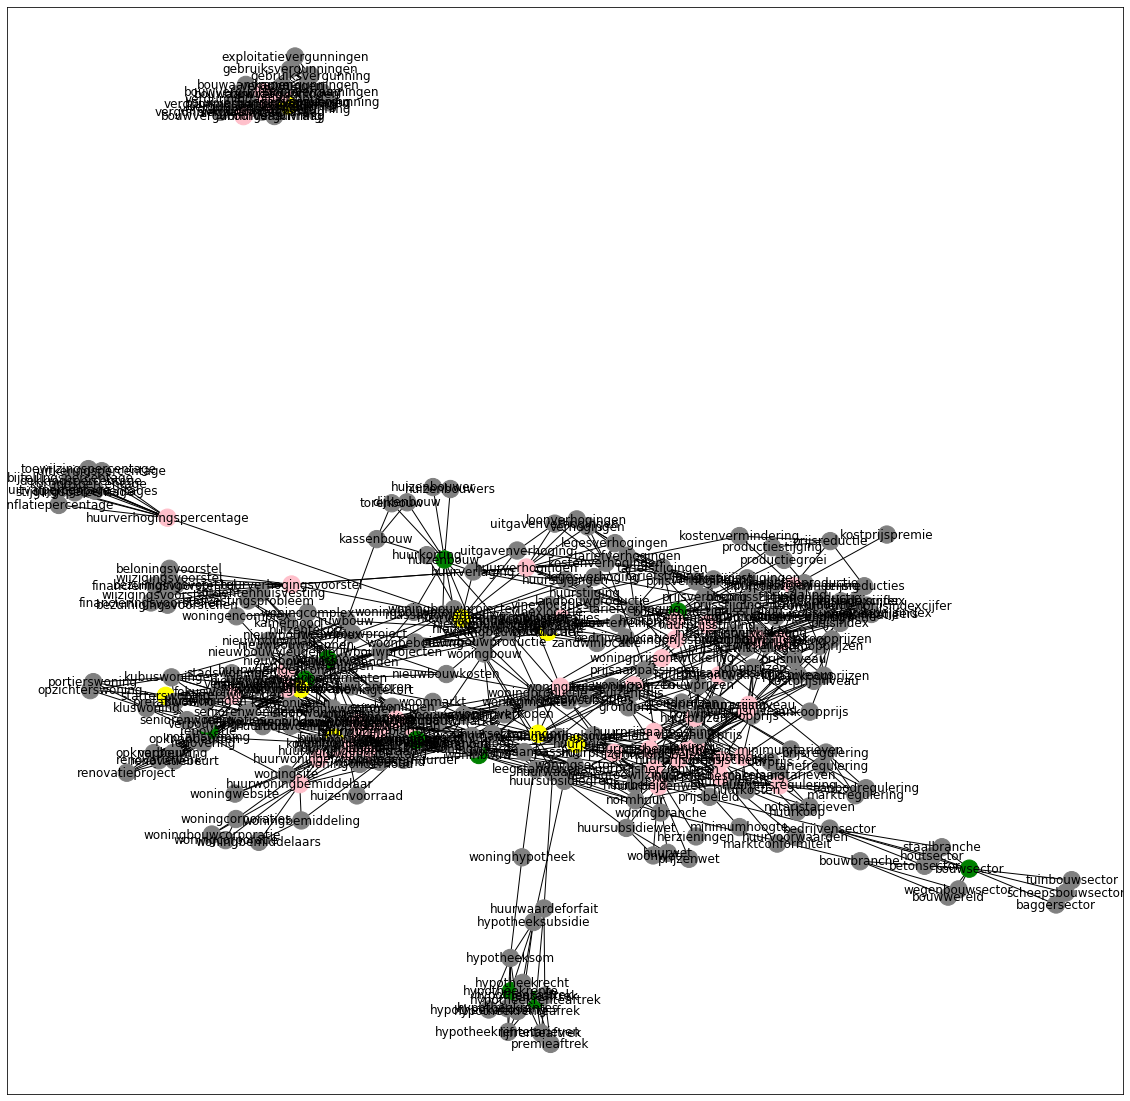

In [122]:
plt.figure(figsize=(20,20))
nx.draw_networkx(graph, node_color=nx.get_node_attributes(graph, 'color').values(), with_labels=True, 
                 pos=nx.spring_layout(graph, weight='weight', scale=10))

In [126]:
print('{} nodes in the network, {} query terms, so {} added'.format(len(graph), len(df_sub), len(graph)-len(df_sub)))

338 nodes in the network, 71 query terms, so 267 added


(array([  5.,  19., 103., 197., 257., 340., 199., 133.,  78.,  31.]),
 array([0.71124911, 0.73900158, 0.76675406, 0.79450653, 0.822259  ,
        0.85001147, 0.87776394, 0.90551641, 0.93326888, 0.96102135,
        0.98877382]),
 <a list of 10 Patch objects>)

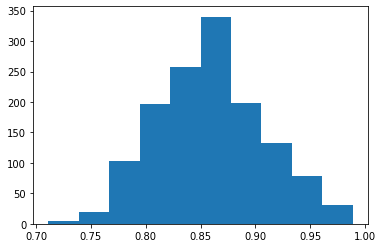

In [113]:
# Look at distribution of scores
plt.hist(nx.get_edge_attributes(graph, 'weight').values())

We create a different graph, looking at the nearest neighbor set of the complete set of query terms. We draw an edge between nodes if their similarity is above a threshold value.

We see that the big difference is that the new words (marked in grey) are close to most of the existing words. That means they are more likely to be indeed relevant, but we are not so much exploring the complete space.

Note that the comparison is not completely fair, because here the edges are threshold-based and in the graph above they were based on the top-10, so the density could be different. But in the histogram above we see that all values of the top-10 were above 0.7, so by taking this as cut-off value we are not missing any neighbors from the top-10 (so probably this network is denser)

We take 300 neighbors, to be close to the number of nodes in the network above.

In [119]:
# Different type of graph: similar to all
def graph_for_all(df_sub, cut_off=0.7, num_neighbors=50):
    graph = nx.Graph()

    neighbors = emb.wv.most_similar(df_sub['query'].unique(), topn=num_neighbors)
    for _, row in df_sub.iterrows():
        word = row['query']
        graph.add_node(word, category=row['category'], color=color_map.get(row['category']))
        for neighbor, _ in neighbors: 
            if not graph.has_node(neighbor):
                graph.add_node(neighbor, category='neighbor', color=color_map['neighbor'])
            score = emb.wv.similarity(word, neighbor)
            if score > cut_off:
                graph.add_edge(word, neighbor, weight=score)
    plt.figure(figsize=(20,20))
    nx.draw_networkx(graph, node_color=nx.get_node_attributes(graph, 'color').values(), with_labels=True, 
                 pos=nx.spring_layout(graph, weight='weight', scale=10, k=4/np.sqrt(len(graph.nodes))))
    plt.show()
    return graph

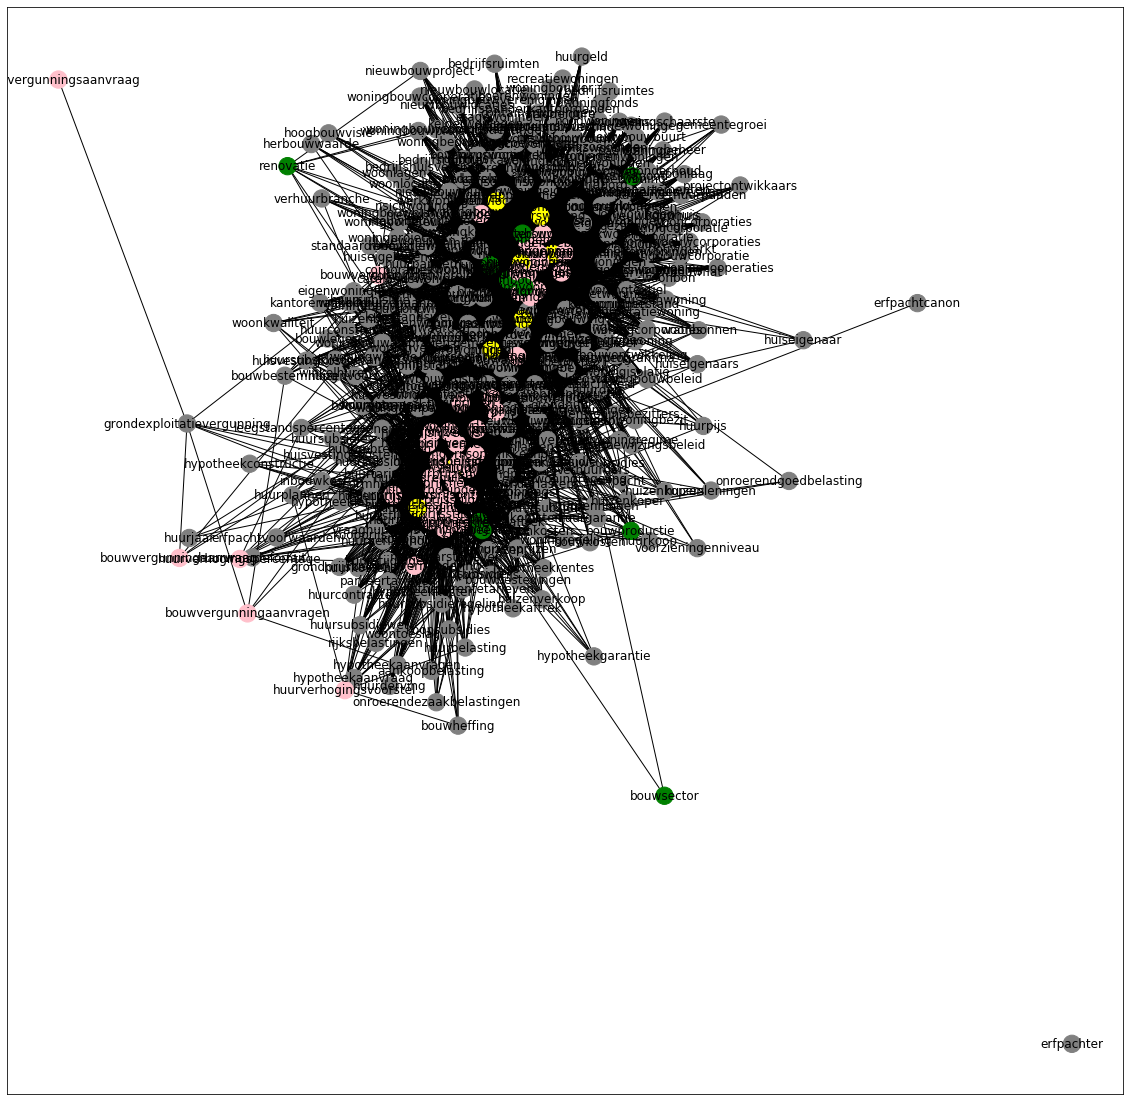

In [127]:
graph_for_all(df_sub, cut_off=0.7, num_neighbors=300)

Let's see what happens if we are more strict in the cutoff value.
We see that quite a few of the 'nearest neighbors' to all nodes are not very close to any of the individual query terms, although at first sight they do look relevant.

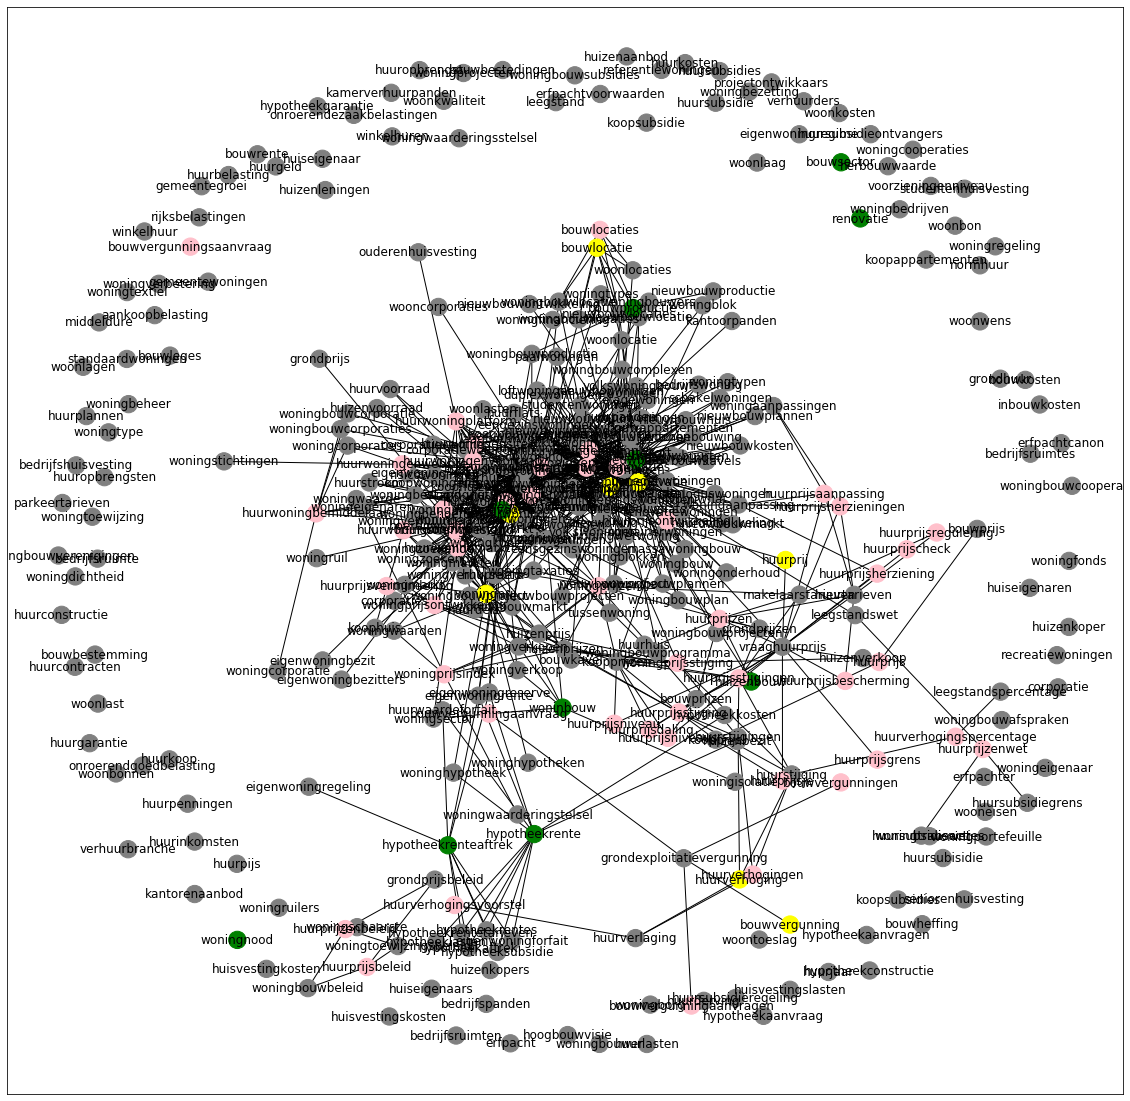

In [129]:
graph_for_all(df_sub, cut_off=0.8, num_neighbors=300)